In [1]:
import sys
import os
proj_path = "/home/mt622/GitHubRepos/FractionalBrownianMotion"
proj_path = os.path.abspath(proj_path)
sys.path.append(proj_path)
print(sys.path)

['/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/generative_modelling/RecursiveVPSDE/ParameterEstimation/PM', '/Users/marcos/GitHubRepos/FractionalBrownianMotion', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python310.zip', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10', '/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/lib-dynload', '', '/Users/marcos/GitHubRepos/FractionalBrownianMotion/venv/lib/python3.10/site-packages', '/home/mt622/GitHubRepos/FractionalBrownianMotion']


In [1]:
from configs import project_config
import matplotlib.pyplot as plt
import numpy as np
import torch

In [3]:
from configs.RecursiveVPSDE.recursive_PostMeanScore_fOU_T256_H05_tl_5data import get_config as get_config_postmean
config_postmean = get_config_postmean()

rng = np.random.default_rng()
num_simulated_paths = 500
drift_eval_diff_time = int(config_postmean.max_diff_steps - 9000)
data_shape = (num_simulated_paths, 1, 1)
device = "cpu"

revDiff_time_scale = torch.linspace(start=config_postmean.end_diff_time, end=config_postmean.sample_eps,
                                 steps=config_postmean.max_diff_steps).to(device)
real_time_scale = torch.linspace(start=1 / config_postmean.ts_length, end=1, steps=config_postmean.ts_length).to(device)

max_diff_steps = config_postmean.max_diff_steps
sample_eps = config_postmean.sample_eps
mean_rev = config_postmean.mean_rev
ts_step = 1 / config_postmean.ts_length
eval_ts_length = 256

In [4]:
from scipy.stats import wasserstein_distance
import ot
def bootstrap_test_wasserstein(sample1, sample2, num_bootstrap=1000):
    # Step 1: Compute the observed Wasserstein distance
    M = ot.dist(sample1, sample2, metric='euclidean')
    a = np.ones((500,)) / 500  # Uniform weights for X
    b = np.ones((500,)) / 500  # Uniform weights for Y

    #observed_distance = wasserstein_distance(sample1, sample2)
    print(a.shape, b.shape, M.shape)
    observed_distance = ot.lp.emd2(a, b, M = M)
    # Step 2: Bootstrap samples
    bootstrap_distances = []
    combined = np.vstack([sample1, sample2])
    for _ in range(num_bootstrap):
        np.random.shuffle(combined)
        obs_perm = combined[:sample1.shape[0], :]
        sim_perm = combined[sample2.shape[0]:, :]

        # Step 3: Compute Wasserstein distance for bootstrap samples
        M = ot.dist(obs_perm, sim_perm, metric='euclidean')
        boot_distance = (ot.lp.emd2(a, b, M = M))
        #boot_distance = wasserstein_distance(boot_sample1, boot_sample2)
        bootstrap_distances.append(boot_distance)

    # Step 4: Calculate p-value and confidence intervals
    bootstrap_distances = np.array(bootstrap_distances)
    print(bootstrap_distances, observed_distance)
    p_value = np.mean(bootstrap_distances >= observed_distance)


    return observed_distance, p_value

(500,) (500,) (500, 500)
[4.06725534 4.07008113 4.01178478 4.05389755 4.00727944 3.97625851
 3.97137116 3.98151053 3.93440718 4.05952007 3.96327271 4.29655801
 4.0451055  4.20218255 4.072726   3.93237378 4.0940987  3.97812482
 4.01363597 3.96457086 4.24422875 4.00347154 3.93765329 4.04188816
 4.1146876  3.95889567 4.02955541 3.99674459 3.97740623 4.01031484
 3.96066229 4.04061044 4.03057826 3.93998876 4.09766664 4.03783889
 3.95863564 4.10636335 4.09269917 3.95337169 3.97119475 3.9203785
 4.0677514  3.90024289 4.24557039 4.0431249  3.97586645 4.02001594
 4.00135084 4.03691576 4.15001859 3.99100523 4.07244963 4.02599559
 4.0456914  4.03115047 4.0045039  4.00236461 3.99917654 4.11600877
 4.06957492 4.04623649 4.00338733 3.99774542 4.01919429 3.94738566
 4.11448608 4.04558501 4.06695307 4.05849863 4.01494838 4.11534719
 4.10361065 4.05957259 4.05626581 4.03185213 3.93779083 3.97499998
 4.10585616 4.07995835 3.91187348 3.90590585 4.06442448 4.02931001
 3.96036883 4.00027873 4.01908324 3.94

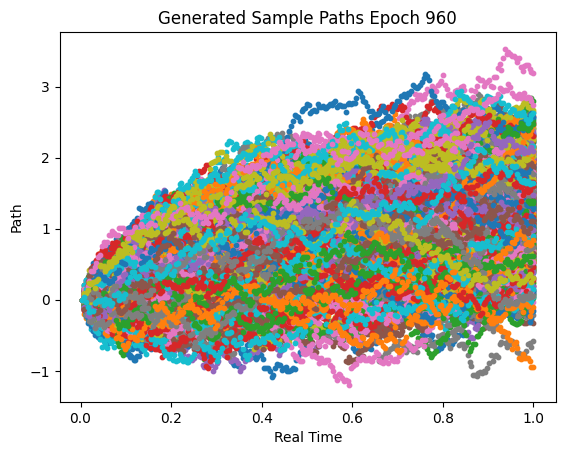

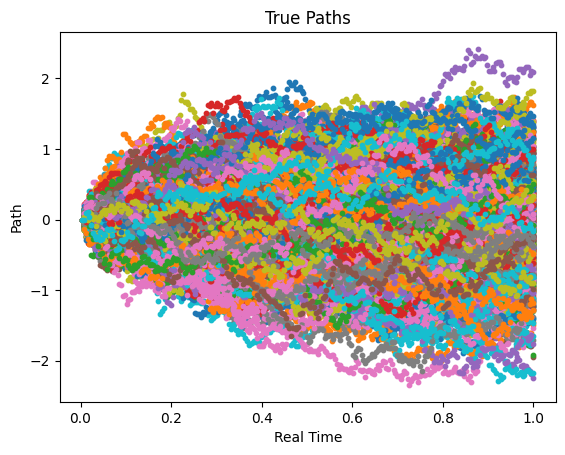

In [8]:
# Plot the drift estimator for different sample paths across time
for t in config_postmean.max_epochs:
    save_path = project_config.ROOT_DIR + f"experiments/results/TSPM_DriftEvalExp_{t}Nep_{config_postmean.loss_factor}LFactor"
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths")
        synthetic_paths = np.load(config_postmean.data_path)[np.random.choice(np.arange(config_postmean.dataSize), 500, replace=False),:]
        synthetic_paths = np.concatenate([np.zeros((synthetic_paths.shape[0], 1)), synthetic_paths[:,:-1]], axis=1)
        synthetic_paths = synthetic_paths[:,:postMean_prevPaths.shape[1]]
        print(bootstrap_test_wasserstein(postMean_prevPaths.numpy(), synthetic_paths)[1])
        for pathid in range(num_simulated_paths):
            plt.scatter(real_time_scale[:eval_ts_length].cpu(), postMean_prevPaths[pathid,:].cpu(), s=10)
        plt.xlabel("Real Time")
        plt.ylabel("Path")
        plt.title(f"Generated Sample Paths Epoch {t}")
        plt.show()
        plt.close()
        for pathid in range(num_simulated_paths):
            plt.scatter(real_time_scale[:eval_ts_length].cpu(), synthetic_paths[pathid,:], s=10)
        plt.xlabel("Real Time")
        plt.ylabel("Path")
        plt.title(f"True Paths")
        plt.show()
        plt.close()
        del postMean_prevPaths
    except FileNotFoundError:
        pass

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


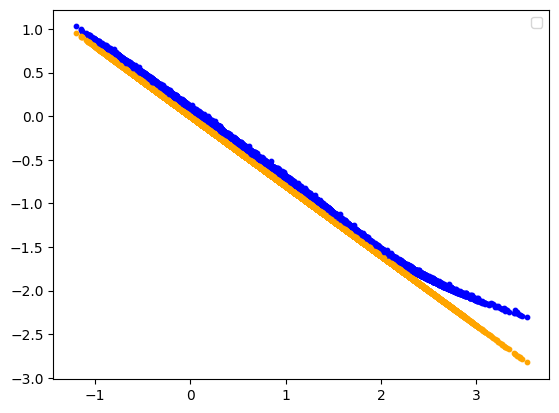

torch.Size([256, 10000])
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_DriftEvalExp_1440Nep_0LFactor_prevPaths'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_DriftEvalExp_1920Nep_0LFactor_prevPaths'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_DriftEvalExp_2920Nep_0LFactor_prevPaths'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_DriftEvalExp_6920Nep_0LFactor_prevPaths'
[Errno 2] No such file or directory: '/Users/marcos/GitHubRepos/FractionalBrownianMotion/experiments/results/TSPM_DriftEvalExp_12920Nep_0LFactor_prevPaths'


In [29]:
experiment_emses = {t: None for t in config_postmean.max_epochs}
experiment_rel_emses = {t: None for t in config_postmean.max_epochs}
for t in config_postmean.max_epochs:
    save_path = project_config.ROOT_DIR + f"experiments/results/TSPM_DriftEvalExp_{t}Nep_{config_postmean.loss_factor}LFactor"
    try:
        postMean_prevPaths = torch.load(save_path + "_prevPaths")
        drift_est = torch.load(save_path + "_driftEst")
        true_drift = torch.load(save_path + "_driftTrue")
        bias2 = torch.pow(true_drift.unsqueeze(-1) - drift_est,2).mean(axis=0)
        #variance = torch.var(drift_est, axis=0)
        del drift_est, postMean_prevPaths
        emses = bias2 #+ variance
        experiment_emses[t] = emses
        print((emses / torch.pow(true_drift, 2).mean(axis=0).unsqueeze(-1)).shape)
        experiment_rel_emses[t] = emses / torch.pow(true_drift, 2).mean(axis=0).unsqueeze(-1)
    except FileNotFoundError as e:
        print(e)
        pass

In [30]:
save_path = project_config.ROOT_DIR + f"experiments/results/TSPM_DriftEvalExp_{960}Nep_{config_postmean.loss_factor}LFactor"
postMean_prevPaths = torch.load(save_path + "_prevPaths")
drift_est = torch.load(save_path + "_driftEst")
true_drift = torch.load(save_path + "_driftTrue")

In [32]:
true_drift.shape

torch.Size([500, 256])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


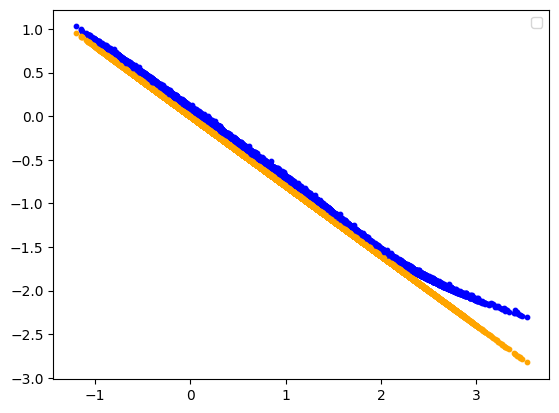

In [34]:
for pathid in range(drift_est.shape[0]):
    plt.scatter(postMean_prevPaths[pathid,:], drift_est[pathid,:,9990], s=10, color="blue")
    plt.scatter(postMean_prevPaths[pathid,:], true_drift[pathid,:], s=10, color="orange")
plt.legend()
plt.show()
plt.close()

In [ ]:
for t in range(eval_ts_length):
    for key, values in experiment_emses.items():
        try:
            plt.scatter(np.arange(0, config_postmean.max_diff_steps), values[t, :], s=10, label=f"{key}")
            plt.title(f"Bias2 + Variance of Drift Estimator at Real Time {t}")
        except TypeError:
            pass
    plt.legend()
    plt.xlabel("Diffusion Time")
    plt.yscale("log")
    plt.show()
    plt.close()

tensor(0.0078) 960


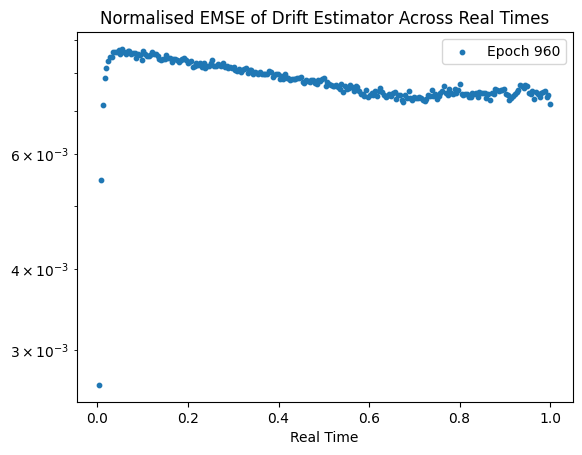

In [24]:
# Compute mean and bias2 for the drift estimates across different diffusion times
for Nepoch in config_postmean.max_epochs:
    try:
        rel_emses = experiment_emses[Nepoch][:, 9990]
        print(torch.mean(rel_emses[1:]), Nepoch)
        plt.scatter(real_time_scale, rel_emses, s=10, label=f"Epoch {Nepoch}")
    except TypeError:
        pass
plt.title(f"Normalised EMSE of Drift Estimator Across Real Times")
plt.xlabel("Real Time")
plt.legend()
plt.yscale("log")
plt.show()
plt.close()